In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import random
import os, glob, math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "/home/santari/Projects/motor_gpt/data/processed/svla_so101_actions.pt"

In [3]:
payload = torch.load(DATA_PATH, map_location='cpu')
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [4]:
if isinstance(payload, dict):
    episodes = payload['episodes']
else:
    episodes = payload


print(f"Loaded {len(episodes)} episodes")
print("Example episode tensor shape:", episodes[0].shape)  # (T_ep, 6)
lengths = [ep.shape[0] for ep in episodes]
print("Episode lengths: min/max/mean =", min(lengths), max(lengths), sum(lengths)/len(lengths))

Loaded 50 episodes
Example episode tensor shape: torch.Size([303, 6])
Episode lengths: min/max/mean = 183 306 238.78


In [5]:
SEED = 42
BLOCK_SIZE = 128

N_TEST = 5
N_VAL = 5

# sanity: ensure block_size fits in shortest episode for next-step targets
assert min(lengths) > BLOCK_SIZE + 1, "BLOCK_SIZE too big for at least one episode."

indices = list(range(len(episodes)))
random.seed(SEED)
random.shuffle(indices)

test_ids = indices[:N_TEST]
val_ids  = indices[N_TEST:N_TEST+N_VAL]
train_ids = indices[N_TEST+N_VAL:]

train_eps = [episodes[i] for i in train_ids]
val_eps   = [episodes[i] for i in val_ids]
test_eps  = [episodes[i] for i in test_ids]

print("Split counts (train/val/test):", len(train_eps), len(val_eps), len(test_eps))
print("Train min/max length:", min(ep.shape[0] for ep in train_eps), max(ep.shape[0] for ep in train_eps))
print("Test indices:", test_ids)
print("Val indices:", val_ids)
print("Train indices:", train_ids)

Split counts (train/val/test): 40 5 5
Train min/max length: 183 306
Test indices: [25, 23, 19, 11, 4]
Val indices: [45, 26, 9, 29, 16]
Train indices: [31, 21, 12, 3, 39, 38, 10, 24, 35, 0, 43, 18, 33, 48, 41, 30, 28, 20, 22, 42, 46, 36, 32, 44, 13, 49, 47, 2, 27, 37, 5, 34, 6, 8, 14, 15, 17, 1, 7, 40]


In [6]:
print(type(episodes))
print(type(episodes[0]))
print(type(episodes[0][0]))

<class 'list'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


“I don’t care which index you give me.
Each call is a fresh draw from my training distribution.”

in this case we're designed idx to be the trigger not the identify
in ActionWindowDataset, we are randomizing:
1. which episode is sampled from
2. where the window starts inside that episode

There is no such thing as “training on the dataset.”
There is only training on a distribution induced by the dataset + sampler.

2. How to train yourself to think this way

You don’t learn this by memorizing probability formulas.
You learn it by rephrasing everything as a distribution + expectation.

From now on, whenever you see code, ask:

“What random variable is being sampled here?”
“What distribution is being induced?”
“What expectation is being approximated?”

In [7]:
def prep_episode_metadata(episodes, trajectory_len):
    max_starts = []
    for ep in episodes:
        T = ep.shape[0]
        max_start = T - trajectory_len - 1
        max_starts.append(max_start)
    return max_starts


In [26]:
def get_batch_train(episodes, window_lens, trajectory_len, batch_size, device):
    # generate which episodes to draw from for this batch
    idx_samples = torch.randint(0,len(episodes), (batch_size,))
    x_list ,y_list = [], []
 
    for sample in range(batch_size):
  
        eps_idx = idx_samples[sample].item()
        eps = episodes[eps_idx]

        # generate a randon starting_idx within our valid range
        max_start = window_lens[eps_idx]
        start = torch.randint(0, max_start+1, (1,)).item()
       
        x = eps[start : start + trajectory_len]
        y = eps[start +1 : start + trajectory_len + 1]

        x_list.append(x)
        y_list.append(y)

    X = torch.stack(x_list, dim=0).to(device)
    Y = torch.stack(y_list, dim=0).to(device)

    return X, Y

In [9]:
window_lens = prep_episode_metadata(train_eps, trajectory_len=128)

print(window_lens)
print(len(window_lens))
print(type(window_lens))

[143, 95, 81, 54, 109, 127, 87, 94, 133, 174, 152, 85, 110, 143, 177, 159, 95, 114, 108, 134, 174, 125, 141, 132, 102, 142, 130, 101, 74, 98, 102, 78, 95, 97, 94, 97, 114, 137, 74, 164]
40
<class 'list'>


In [10]:
X, Y = get_batch_train( train_eps, window_lens, batch_size=4, trajectory_len=128, device="cpu")

print(X.shape)
print(Y.shape)

torch.Size([4, 128, 6])
torch.Size([4, 128, 6])


In [14]:
traj0 = X[0]   # (128, 6)
print(traj0[:5])          # first 5 timesteps
print(traj0[-5:])         # last 5 timesteps
print("min per joint:", traj0.min(dim=0).values)
print("max per joint:", traj0.max(dim=0).values)

tensor([[ 38.1618, -98.9053,  99.3628,  73.2257, -53.5043,   1.2365],
        [ 39.5588, -98.9053,  99.3628,  73.5657, -53.5043,   1.2365],
        [ 41.5441, -98.9053,  98.9076,  73.6507, -53.5043,   1.2365],
        [ 43.3088, -98.9053,  98.0883,  73.6507, -53.5043,   1.2365],
        [ 43.8971, -98.9053,  97.2690,  73.2257, -53.2601,   1.2365]])
tensor([[ 74.4118, -31.9579,  42.5580,  72.5457, -28.4005,   1.2365],
        [ 75.9559, -32.2105,  42.4670,  73.3107, -28.4005,   1.2365],
        [ 77.2059, -33.2211,  42.4670,  73.8207, -28.4005,   1.2365],
        [ 77.8676, -34.4000,  42.4670,  74.0756, -28.3516,   1.2365],
        [ 78.6029, -35.4105,  42.3760,  74.1606, -28.3516,   1.2365]])
min per joint: tensor([ 38.1618, -98.9053,  42.3760,  45.6864, -53.5043,   0.6182])
max per joint: tensor([ 78.6029, -12.6737,  99.3628,  74.1606, -28.3516,  20.9428])


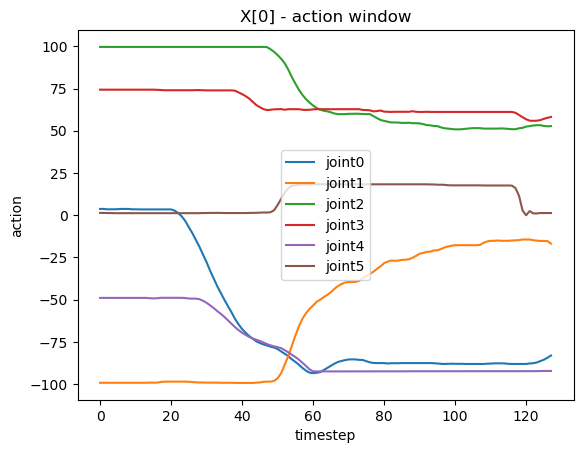

In [17]:


def plot_trajectory(traj, title="trajectory"):
    # traj: (T, 6)
    T = traj.shape[0]
    t = range(T)
    plt.figure()
    for j in range(traj.shape[1]):
        plt.plot(t, traj[:, j].numpy(), label=f"joint{j}")
    plt.title(title)
    plt.xlabel("timestep")
    plt.ylabel("action")
    plt.legend()
    plt.show()

plot_trajectory(X[3].cpu(), "X[0] - action window")


In [1]:
def fit_action_normalizer(episodes, eps=1e-6):
    # episodes: list of (T, A)
    # think [(T1, A), (T2, A), ...]
    A_dim = episodes[0].shape[1]
    total = torch.zeros(A_dim) # dim 6
    total2 = torch.zeros(A_dim) # dim 6
    count = 0

    # so it seems ive set myself up to compute mean and std per action dimension

    for ep in episodes:
        ep = ep.float()
        total += ep.sum(dim=0) # sum over time, get (A,)
        total2 += (ep * ep).sum(dim=0) # sum over time, get (A,)
        count += ep.shape[0] # total number of timesteps

    mean = total / count
    var = total2 / count - mean * mean #using second momemt trick to calculate variance
    std = torch.sqrt(torch.clamp(var, min=eps))
    return mean, std

def normalize_episodes(episodes, mean, std):
    return [(ep.float() - mean) / std for ep in episodes]

def denormalize_actions(x, mean, std):
    return x * std + mean


okay so ive visualized this and now its time to inherit my previous architecture


### Attention

In [18]:
class SelfAttentionHead(nn.Module):
    def __init__(self, head_dim, embed_dim, traj_size, dropout=0.0):
        super().__init__()
        # linear projections for Q, V, K
        self.key = nn.Linear(embed_dim, head_dim, bias=False)
        self.query = nn.Linear(embed_dim, head_dim, bias=False)
        self.value = nn.Linear(embed_dim, head_dim, bias=False)
        mask = torch.tril(torch.ones(traj_size, traj_size)).view(1, traj_size, traj_size)
        self.atten_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)
        self.register_buffer("mask", mask)

    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x) #(B, T, H)
        k = self.key(x)
        v = self.value(x)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))  # (B, T, T)
        att = att.masked_fill(self.mask[:,:T,:T]==0, float('-inf'))
        att = F.softmax(att, dim=-1)  # (B, T, T)
        att = self.atten_drop(att)

        out = att @ v  # (B, T, H)
        out = self.resid_drop(out)

        return out
    

In [19]:
# test the SelfAttentionHead
head = SelfAttentionHead(head_dim=16, embed_dim=32, traj_size=8)
x = torch.randn(4, 8, 32)  # (B, T, C)
out = head(x)
print(out.shape)

torch.Size([4, 8, 16])


In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, head_dim, traj_size, dropout=0.0):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(head_dim, embed_dim, traj_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_dim, embed_dim, bias=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        multi_head_out = [h(x) for h in self.heads]  # list of (B, T, head_size)
        multi_head_concat = torch.cat(multi_head_out, dim=-1) # (B, T, num_heads * head_size)

        out = self.drop(self.proj(multi_head_concat))  # (B, T, embed_dim)

        return out

In [21]:
mha = MultiHeadAttention(num_heads=4, embed_dim=32, head_dim=8, traj_size=8, dropout=0.0)
x = torch.randn(4, 8, 32)
out = mha(x)
print(out.shape)

torch.Size([4, 8, 32])


### Transformer Block

In [22]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, expansion=4, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, expansion*embed_dim),
            nn.GELU(),
            nn.Linear(expansion*embed_dim, embed_dim),
            nn.Dropout(dropout),
        )
    def forward(self, x): return self.net(x)

class Block(nn.Module):
    def __init__(self, embed_dim, n_head, block_size, mlp_expansion=4, dropout=0.0):
        super().__init__()
        assert embed_dim % n_head == 0
        head_size = embed_dim // n_head
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(n_head, embed_dim, head_size, block_size, dropout)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = FeedForward(embed_dim, expansion=mlp_expansion, dropout=dropout)

    def forward(self, x):
        # TODO
        x = x + self.attn(self.ln1(x)) # skip connection
        x = x + self.mlp(self.ln2(x)) # skip connection

        return x

In [25]:
mean, std = fit_action_normalizer(train_eps)
train_eps_n = normalize_episodes(train_eps, mean, std)
val_eps_n   = normalize_episodes(val_eps, mean, std)
test_eps_n  = normalize_episodes(test_eps, mean, std)

print("mean:", mean)
print("std:", std)

mean: tensor([  5.0858, -56.1276,  65.6337,  69.0972, -54.5309,   6.8955])
std: tensor([45.5936, 36.2125, 28.6296, 13.1797, 18.0960,  9.0646])


### Motor GPT

In [2]:
class MotorGPT(nn.Module):
    def __init__(self, action_size=6, embed_dim=192, traj_size=128, n_layer=4, n_head=4, dropout=0.0):
        super().__init__()
        self.action_size = action_size
        self.traj_size = traj_size

        # “token embedding” for continuous actions
        self.token_emb = nn.Linear(action_size, embed_dim, bias=False)
        self.pos_emb   = nn.Embedding(traj_size, embed_dim)

        self.blocks = nn.ModuleList([
            Block(embed_dim, n_head, traj_size, dropout=dropout)
            for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(embed_dim)

        # regression head back to action space
        self.head = nn.Linear(embed_dim, action_size, bias=True)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        # NanoGPT init is fine conceptually, but add LayerNorm explicitly
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x, targets=None):
        """
        x:       (B, T, A)  normalized actions
        targets: (B, T, A)  next-step normalized actions
        """
        B, T, A = x.shape
        assert T <= self.traj_size, "Sequence length exceeds traj_size"


        #token and position embedding
        tok = self.token_emb(x)  # (B, T, E)
        pos = self.pos_emb(torch.arange(T, device=x.device)).unsqueeze(0)  # (1, T, E)
        h = tok + pos

        #pass through Transformer blocks
        for block in self.blocks:
            h = block(h)

        # regression head 
        h = self.ln_f(h)
        pred = self.head(h)      # (B, T, A)

        loss = None
        if targets is not None:
            loss = F.mse_loss(pred, targets)  # regression v1

        return pred, loss

    @torch.no_grad()
    def generate(self, seed_actions, max_new_steps=100, noise_std=0.0):
        """
        seed_actions: (B, T0, A) normalized actions
        returns:      (B, T0+max_new_steps, A) normalized actions
        """
        self.eval()
        out = seed_actions
        for _ in range(max_new_steps):
            cond = out[:, -self.traj_size:, :]      # crop context, so only last traj_size steps
            pred, _ = self(cond)                    # (B, Tcond, A), this includes the whole context
            next_a = pred[:, -1, :]                 # (B, A), take only the last time step

            # optional stochasticity (since MSE tends to be “average”)
            if noise_std > 0:
                next_a = next_a + noise_std * torch.randn_like(next_a)

            out = torch.cat([out, next_a.unsqueeze(1)], dim=1)
        return out


NameError: name 'nn' is not defined

In [ ]:
def estimate_loss(model, train_eps, val_eps, train_wlens, val_wlens,
                  trajectory_len, batch_size, eval_iters, device):
    # samples random batches from train and val sets, computes mean loss
    model.eval()
    out = {}
    with torch.no_grad():
        for name, eps, wl in [("train", train_eps, train_wlens), ("val", val_eps, val_wlens)]:
            losses = []
            for _ in range(eval_iters):
                xb, yb = get_batch_train(eps, wl, trajectory_len, batch_size, device)
                _, loss = model(xb, yb)
                losses.append(loss.item())
            out[name] = float(np.mean(losses))
    model.train()
    return out # returns {"train": mean_loss, "val": mean_loss}


def save_checkpoint(path, model, optimizer, step, best_val=None, metadata=None):
    # builds a directory and saves model and optimizer state dicts
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "step": step,
        "best_val": best_val,
        "metadata": metadata or {},
    }
    torch.save(state, path)


def train_model(model, train_eps, val_eps, train_wlens, val_wlens,
                trajectory_len=128, batch_size=64, max_iters=2000,
                eval_interval=100, lr=3e-4, weight_decay=0.1,
                grad_clip=1.0, device="cuda", checkpoint_dir=None,
                save_interval=None, save_best=True, metadata=None):

    model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.95))

 
    if checkpoint_dir is not None:
        os.makedirs(checkpoint_dir, exist_ok=True)
        if save_interval is None:
            save_interval = eval_interval

    best_val = float("inf")
    training_losses, validation_losses, eval_steps = [], [], []

    for it in range(max_iters):
        # sample batch, compute loss
        xb, yb = get_batch_train(train_eps, train_wlens, trajectory_len, batch_size, device)
        _, loss = model(xb, yb)

        # backprop and update
        opt.zero_grad(set_to_none=True)
        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()

        #periodic evaluation
        if it % eval_interval == 0 or it == max_iters - 1:
            est = estimate_loss(model, train_eps, val_eps, train_wlens, val_wlens,
                                trajectory_len, batch_size, eval_iters=25, device=device)
            print(f"iter {it:5d} | train {est['train']:.6f} | val {est['val']:.6f}")
            training_losses.append(est["train"])
            validation_losses.append(est["val"])
            eval_steps.append(it)

            if checkpoint_dir is not None:
                if save_best and est["val"] < best_val:
                    best_val = est["val"]
                    best_path = os.path.join(checkpoint_dir, "best.pt")
                    save_checkpoint(best_path, model, opt, it, best_val=best_val, metadata=metadata)

                if it % save_interval == 0 or it == max_iters - 1:
                    ckpt_path = os.path.join(checkpoint_dir, f"ckpt_{it:06d}.pt")
                    save_checkpoint(ckpt_path, model, opt, it, best_val=best_val, metadata=metadata)

    plt.figure()
    plt.plot(eval_steps, training_losses, label="train")
    plt.plot(eval_steps, validation_losses, label="val")
    plt.xlabel("Iteration")
    plt.ylabel("MSE loss")
    plt.title("MotorGPT Train/Val Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


iter     0 | train 0.565845 | val 0.542630
iter   100 | train 0.005835 | val 0.006347
iter   199 | train 0.002719 | val 0.003362


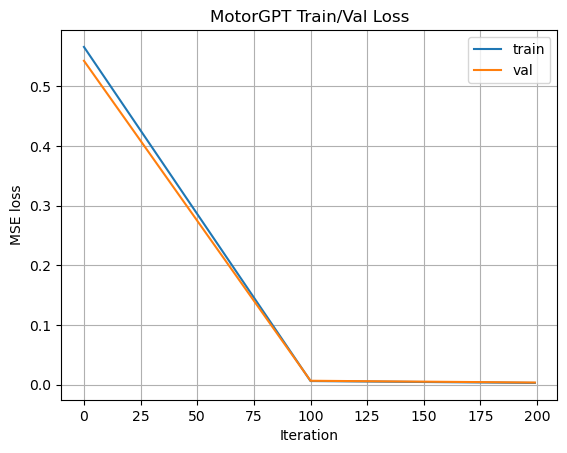

In [94]:
trajectory_len = 128

train_wlens = prep_episode_metadata(train_eps_n, trajectory_len)
val_wlens   = prep_episode_metadata(val_eps_n, trajectory_len)

model = MotorGPT(action_size=6, embed_dim=192, traj_size=trajectory_len, n_layer=4, n_head=4, dropout=0.0)

train_model(model,
            train_eps=train_eps_n,
            val_eps=val_eps_n,
            train_wlens=train_wlens,
            val_wlens=val_wlens,
            trajectory_len=trajectory_len,
            batch_size=64,
            max_iters=200,
            eval_interval=100,
            lr=3e-4,
            device=device)


In [95]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = next(model.parameters()).device
model.eval()

# pick an episode and a start index
ep = train_eps_n[0]               # normalized episode: (T_ep, A)
T0 = 32                           # seed length
start = 0                         # or np.random.randint(0, ep.shape[0]-T0-1)

seed = ep[start:start+T0].unsqueeze(0).to(device)   # (1, T0, A)
print("seed shape:", seed.shape)


seed shape: torch.Size([1, 32, 6])


In [96]:
with torch.no_grad():
    gen_n = model.generate(seed_actions=seed, max_new_steps=200, noise_std=0.00)  # (1, T0+200, A)

print("gen_n shape:", gen_n.shape)


gen_n shape: torch.Size([1, 232, 6])


In [97]:
mean_t = mean.to(device)
std_t  = std.to(device)

gen = gen_n * std_t + mean_t      # (1, T, A) real action space
gen = gen.squeeze(0).cpu().numpy()  # (T, A)


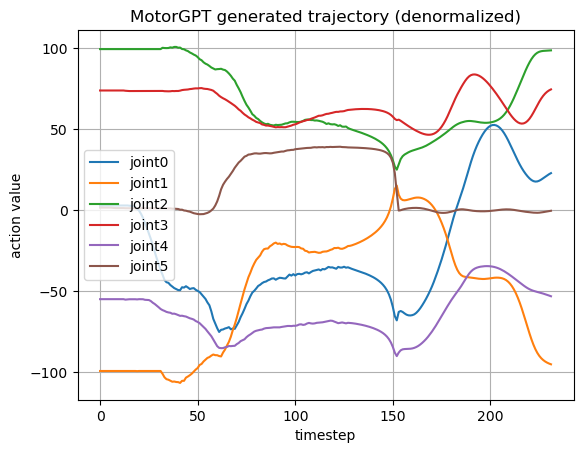

In [98]:
T, A = gen.shape
plt.figure()
for j in range(A):
    plt.plot(gen[:, j], label=f"joint{j}")
plt.title("MotorGPT generated trajectory (denormalized)")
plt.xlabel("timestep")
plt.ylabel("action value")
plt.legend()
plt.grid(True)
plt.show()


In [100]:
import numpy as np
import torch

@torch.no_grad()
def eval_teacher_forcing_mse(model, test_eps, test_wlens, trajectory_len, batch_size, iters, device):
    model.eval()
    losses = []
    for _ in range(iters):
        xb, yb = get_batch_train(test_eps, test_wlens, trajectory_len, batch_size, device)
        _, loss = model(xb, yb)
        losses.append(loss.item())
    return float(np.mean(losses)), float(np.std(losses))

test_wlens = prep_episode_metadata(test_eps_n, trajectory_len)  # if you normalized already

mean_mse, std_mse = eval_teacher_forcing_mse(
    model, test_eps_n, test_wlens,
    trajectory_len=trajectory_len,
    batch_size=64,
    iters=200,
    device=device,
)

print(f"TEST teacher-forcing MSE: {mean_mse:.6f} ± {std_mse:.6f}")


TEST teacher-forcing MSE: 0.003447 ± 0.000086
